In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

In [4]:
def load_dataset():
    
    scale = 25
    p_size_1 = 128 # Compared with 256, which larger may generate round corners
    
    trainPath = r"../tmp_data/data_feng/geb" + str(scale) +  "/"
    #trainPath = r"../tmp_data/"

    x_train_sim = np.load(trainPath + "x_train_sim.npy")
    y_train_sim = np.load(trainPath + "y_train_sim.npy")
    x_test_sim = np.load(trainPath + "x_test_sim.npy")
    y_test_sim = np.load(trainPath + "y_test_sim.npy")
    
    return (x_train_sim, y_train_sim), (x_test_sim, y_test_sim)

(masked_imgs, missing_parts), (X_test, y_test) = load_dataset()

In [72]:
if 1:
    import keras.backend as K
    #this contains both X and Y sobel filters in the format (3,3,1,2)
    #size is 3 x 3, it considers 1 input channel and has two output channels: X and Y
    sobelFilter = K.variable([[[[1.,  1.]], [[0.,  2.]],[[-1.,  1.]]],
                          [[[2.,  0.]], [[0.,  0.]],[[-2.,  0.]]],
                          [[[1., -1.]], [[0., -2.]],[[-1., -1.]]]])

def expandedSobel(inputTensor):

    #this considers data_format = 'channels_last'
    inputChannels = K.reshape(K.ones_like(inputTensor[0,0,0,:]),(1,1,-1,1))
    #if you're using 'channels_first', use inputTensor[0,:,0,0] above

    return sobelFilter * inputChannels

def sobelLoss(yTrue,yPred):

    #get the sobel filter repeated for each input channel
    filt = expandedSobel(yTrue)

    #calculate the sobel filters for yTrue and yPred
    #this generates twice the number of input channels 
    #a X and Y channel for each input channel
    sobelTrue = K.depthwise_conv2d(yTrue,filt)
    sobelPred = K.depthwise_conv2d(yPred,filt)

    #now you just apply the mse:
    return K.mean(K.square(sobelTrue - sobelPred))

def sobelSELoss(yTrue,yPred):

    #get the sobel filter repeated for each input channel
    filt = expandedSobel(yTrue)

    #calculate the sobel filters for yTrue and yPred
    #this generates twice the number of input channels 
    #a X and Y channel for each input channel
    sobelTrue = K.depthwise_conv2d(yTrue,filt)
    sobelPred = K.depthwise_conv2d(yPred,filt)

    #now you just apply the mse:
    return K.abs( K.sum(K.abs(sobelTrue)) - K.sum(K.abs(sobelPred)) )

    
    

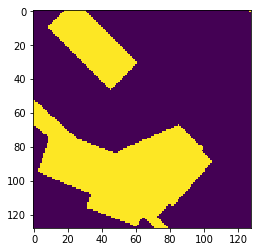

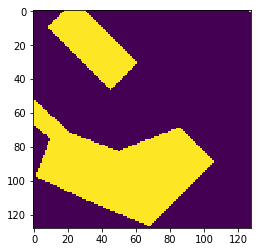

In [11]:
idx = 3263
p_size_1 = 128


In [42]:
yTrue, yPred = np.reshape(y_test[idx], (1, p_size_1,p_size_1, 1)), np.reshape(X_test[idx], (1, p_size_1,p_size_1, 1))

In [43]:
import tensorflow as tf
yTrue = tf.convert_to_tensor(yTrue, np.float32)
yPred = tf.convert_to_tensor(yPred, np.float32)

In [44]:
filt = expandedSobel(yTrue)
print(filt)

Tensor("mul_14:0", shape=(3, 3, 1, 2), dtype=float32)


In [45]:
c = sobelLoss(yTrue,yPred)

#initialize the variable
init_op = tf.initialize_all_variables()

with tf.Session():
  # We can also use 'c.eval()' here.
  print(c.eval())

FailedPreconditionError: Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](Variable)]]
	 [[Node: Mean_7/_1 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_20_Mean_7", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Variable/read', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-e70d3e30ea88>", line 7, in <module>
    [[[1., -1.]], [[0., -2.]],[[-1., -1.]]]])
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 400, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 213, in __init__
    constraint=constraint)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 356, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/array_ops.py", line 125, in identity
    return gen_array_ops.identity(input, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 2071, in identity
    "Identity", input=input, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value Variable
	 [[Node: Variable/read = Identity[T=DT_FLOAT, _class=["loc:@Variable"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](Variable)]]
	 [[Node: Mean_7/_1 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_20_Mean_7", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [19]:
print(yTrue.shape,yPred.shape)

(1, 128, 128, 1) (1, 128, 128, 1)


In [22]:
inputChannels = K.reshape(K.ones_like(yTrue[0,0,0,:]),(1,1,-1,1))
expandedSobel(yTrue).shape

TensorShape([Dimension(3), Dimension(3), Dimension(1), Dimension(2)])

In [23]:
filt = expandedSobel(yTrue)

680.0


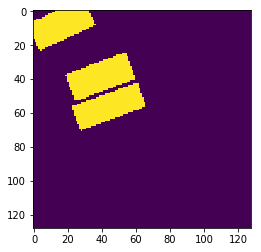

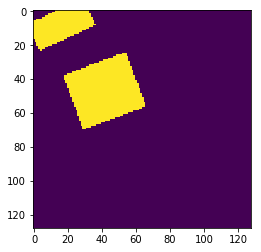

In [80]:
import tensorflow as tf

idx = 7

yTrue, yPred = np.reshape(y_test[idx], (1, p_size_1,p_size_1, 1)), np.reshape(X_test[idx], (1, p_size_1,p_size_1, 1))
yTrue = tf.convert_to_tensor(yTrue, np.float32)
yPred = tf.convert_to_tensor(yPred, np.float32)
loss = sobelSELoss(yTrue,yPred)

#initialize the variable
init_op = tf.initialize_all_variables()

#run the graph
with tf.Session() as sess:
    sess.run(init_op) #execute init_op
    #print the random values that we sample
    print (sess.run(loss))
    
plt.figure()
plt.imshow(np.reshape(X_test[idx], (p_size_1,p_size_1)))
plt.figure()
plt.imshow(np.reshape(y_test[idx], (p_size_1,p_size_1)))